## Preprocess raw images from camera for 3D reconstruction

- background subtraction
- find center position of atom clouds
    - crop into samples where the cloud is centered and in the right format for reconstruction
    - calibrate cloud moving direction on each camera with different time-of-flight(tof) data



In [133]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
import os
import pickle
import csv

path =  os.getcwd()
path = path.replace('\\', r"\\")

cam_list = ["T1","T2","L","F"]
tof_list = ["0","2500us","3000us","3500us","4000us","4500us","5000us"]

# camera gain values correspond to tof_list
g_F = [42,42,42,48,48,48,48]
g_L = [48,48,48,48,48,48,48]
g_T = [30,30,30,35,35,35,42]



In [38]:
def import_img(cam,tof,plot=0,tof_bg = None):
    # import images from cam, of certain tof
    # subtract background when specified

    file_name = path + "\\" + cam + "_" + tof + ".png"
    # import png as grayscale and convert unit8 to int
    img = cv2.imread(file_name,0).astype(int)

    # background subtraction
    if tof_bg != None:
        file_name0 = path + "\\" + cam + "_" + tof_bg + ".png"
        img0 = cv2.imread(file_name0,0).astype(int)
        img -= img0

    if plot == 1:
        plt.imshow(img)
        plt.colorbar()
        plt.axis("off")
        plt.clim([0,256])
        plt.show()

    return img



In [73]:
def centersample(cam,cam0,wx,wy,rotation = 0,plot=0):

    # rotation of the image
    if rotation != 0:
        img = ndimage.rotate(cam0, -30)
    
    # find center of the atom cloud by finding the max val position of sum along each axis
    x0 = np.argmax(cam0.sum(axis=0))
    y0 = np.argmax(cam0.sum(axis=1))

    # the sample should be centered in the newimg frame
    newimg = cam0[(y0-wy):(y0+wy),(x0-wx):(x0+wx)]

    # apply mask for the F camera to remove refelction spots
    if cam == 'F':
        mask = np.zeros_like(newimg, dtype=bool)

        mask[wy-300:wy+300, wx-300:wx+300] = True
        newimg[~mask] = 0
    
    if plot!=0:
        plt.imshow(newimg,aspect='equal',cmap='gray', vmin=0, vmax=255)
        #plt.plot(x0,y0)
        plt.clim([0,256])
        plt.colorbar()
        plt.show()

    return x0, y0, newimg

## Process raw images

#### F

In [127]:
cam = "F"
F_center_position = []

for idx,tof in enumerate(tof_list):
    # different tof may correspond to different camera gain, therefore different background
    bg = "bg_"+str(g_F[idx])
    F = import_img(cam,tof,0,bg)
    x0,y0,Fc = centersample(cam,F,800,800,0)
    F_center_position.append([x0,y0])
    
    with open(path+"\\rec\\"+cam+'_'+tof+'.pkl', 'wb') as f:
        pickle.dump(Fc, f)

with open(path+"\\rec\\"+cam + "_center.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X','Y'])
    writer.writerows(F_center_position)

#### T1

In [129]:
cam = "T1"
T1_center_position = []
for idx,tof in enumerate(tof_list):
    
    plotshow =0
    F = import_img(cam,tof,plotshow)
    if idx<=1:
        x0,y0,Fc = centersample(cam,F,400,400,0,plotshow)
    if idx == 6:
        x0,y0,Fc = centersample(cam,F,500,400,0,plotshow)
    if idx>1 and idx<6:
        x0,y0,Fc = centersample(cam,F,600,400,0,plotshow)

    T1_center_position.append([x0,y0])
    with open(path+"\\rec\\"+cam+'_'+tof+'.pkl', 'wb') as f:
        pickle.dump(Fc, f)

with open(path+"\\rec\\"+cam + "_center.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X','Y'])
    writer.writerows(T1_center_position)

#### T2

In [130]:
cam = "T2"
T2_center_position = []
for idx,tof in enumerate(tof_list):
    plotshow =0
    F = import_img(cam,tof,plotshow)
    if idx<1:
        x0,y0,Fc = centersample(cam,F,500,550,0,plotshow)
    else:
        x0,y0,Fc = centersample(cam,F,600,550,0,plotshow)

    T2_center_position.append([x0,y0])
    with open(path+"\\rec\\"+cam+'_'+tof+'.pkl', 'wb') as f:
        pickle.dump(Fc, f)
        
with open(path+"\\rec\\"+cam + "_center.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X','Y'])
    writer.writerows(T2_center_position)

#### L

In [131]:
cam = "L"
L_center_position = []
for idx,tof in enumerate(tof_list):
    
    plotshow  = 0
    F = import_img(cam,tof,plotshow)
    # remove the bright spot on top right corner
    F[:,1600:]=0
    if idx<2:
        x0,y0,Fc = centersample(cam,F,700,550,0,plotshow)
    else:
        x0,y0,Fc = centersample(cam,F,700,450,0,plotshow)


    L_center_position.append([x0,y0])
    with open(path+"\\rec\\"+cam+'_'+tof+'.pkl', 'wb') as f:
        pickle.dump(Fc, f)

with open(path+"\\rec\\"+cam + "_center.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['X','Y'])
    writer.writerows(L_center_position)

## plot center trajectory

Text(0.5, 1.0, 'F')

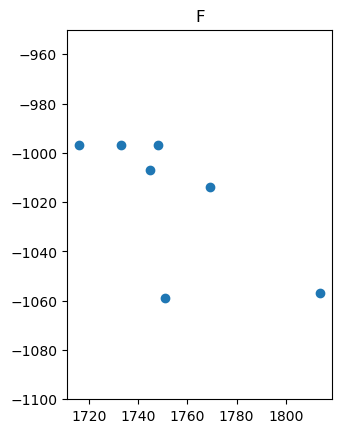

In [117]:
F_p = np.array(F_center_position)
plt.scatter(F_p[:,0],-F_p[:,1])
plt.ylim([-1100,-950])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("F")

Text(0.5, 1.0, 'T1')

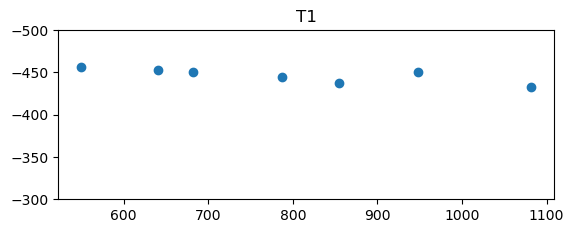

In [118]:
T1_p = np.array(T1_center_position)
plt.scatter(T1_p[:,0],-T1_p[:,1])
plt.ylim([-300,-500])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("T1")

Text(0.5, 1.0, 'T2')

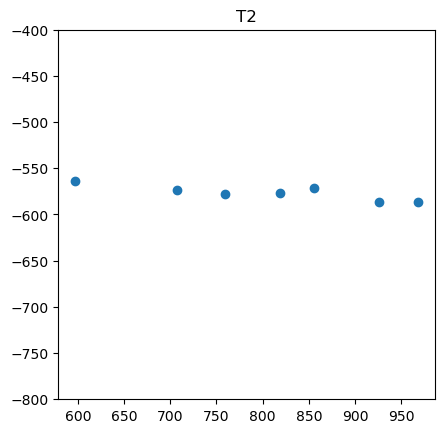

In [119]:
T2_p = np.array(T2_center_position)
plt.scatter(T2_p[:,0],-T2_p[:,1])
plt.ylim([-800,-400])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("T2")

Text(0.5, 1.0, 'L')

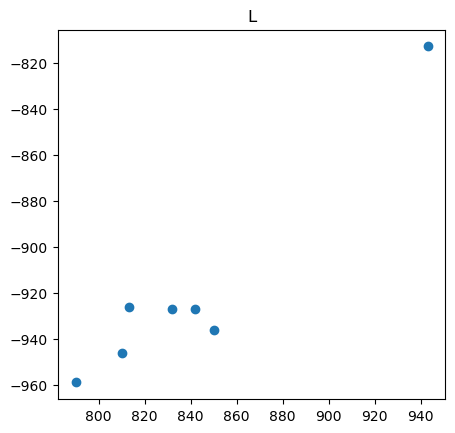

In [134]:
L_p = np.array(L_center_position)
plt.scatter(L_p[:,0],-L_p[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("L")